In [ ]:
!pip install rasterio -q

In [ ]:
# Baixando e instalando SNAP
!wget https://download.esa.int/step/snap/10_0/installers/esa-snap_all_linux-10.0.0.sh -O snap_installer.sh
!chmod +x snap_installer.sh
!./snap_installer.sh -q -overwrite

--2025-01-08 16:40:26--  https://download.esa.int/step/snap/10_0/installers/esa-snap_all_linux-10.0.0.sh
Resolving download.esa.int (download.esa.int)... 151.101.2.132, 151.101.66.132, 151.101.130.132, ...
Connecting to download.esa.int (download.esa.int)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102041590 (1.0G) [application/octet-stream]
Saving to: ‘snap_installer.sh’

snap_installer.sh   100%[===================>]   1.03G   242MB/s    in 4.3s    

2025-01-08 16:41:07 (247 MB/s) - ‘snap_installer.sh’ saved [1102041590/1102041590]



In [ ]:
# Configurando API Python
!/opt/esa-snap/bin/snappy-conf /usr/local/bin/python
import sys
sys.path.append('/root/.snap/snap-python')
!cp -r /root/.snap/snap-python /usr/local/lib/python3.10/site-packages/

OpenJDK 64-Bit Server VM warning: Option AggressiveOpts was deprecated in version 11.0 and will likely be removed in a future release.
Configuring ESA SNAP-Python interface...
Configuration finished successful!
Done. The SNAP-Python interface is located in '/root/.snap/snap-python/esa_snappy'
When using SNAP from Python, either do: sys.path.append('/root/.snap/snap-python')
or copy the 'esa_snappy' module into your Python's 'site-packages' directory.
The executable of the Python environment is located at '/usr/local/bin/python'


In [ ]:
# Verificando se o snap está nas variáveis de ambiente
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/root/.snap/snap-python']


In [ ]:
# Bibliotecas
import esa_snappy
from esa_snappy import GPF
from esa_snappy import ProductIO
from esa_snappy import HashMap
from esa_snappy import jpy
from esa_snappy import ProductUtils
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Funçao para entender os parâmetros de cada operador
def op_info(operator):
  op = esa_snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
  print('Nome do operador: {} '.format(op.getOperatorDescriptor().getName()))
  print('Nome do operador na API: {} '.format(op.getOperatorDescriptor().getAlias()))
  param_desc = op.getOperatorDescriptor().getParameterDescriptors()
  for i in param_desc:
    print('{}: {}\nValor padrao: {}\n'.format(i.getName(), i.getDescription(), i.getDefaultValue()))

In [ ]:
# Acessando os operadores Java
HashMap = jpy.get_type('java.util.HashMap')
parameters = HashMap()

# Função para ler arquivo
def read(file):
  return ProductIO.readProduct(file)

# Funçao para gravar arquivo
def write(product, file):
  ProductIO.writeProduct(product, file, "GeoTIFF")

In [ ]:
# Verificando parâmetros da GLCM
op_info('GLCM')

In [ ]:
# GLCM
def glcm(product):
    parameters.put('windowSizeStr', '9x9')
    parameters.put('angleStr', 'ALL')
    parameters.put('quantizerStr', 'Probabilistic Quantizer')
    parameters.put('quantizationLevelsStr', '32')
    parameters.put('displacement', '4')
    parameters.put('outputContrast', False)
    parameters.put('outputDissimilarity', False)
    parameters.put('outputHomogeneity', False)
    parameters.put('outputASM', False)
    parameters.put('outputEnergy', False)
    parameters.put('outputMAX', False)
    parameters.put('outputEntropy', True)
    parameters.put('outputMean', False)
    parameters.put('outputVariance', False)
    parameters.put('outputCorrelation', False)
    return GPF.createProduct("GLCM", parameters, product)

In [ ]:
# Nomeando resultados
nomes =['Entropy_VV', 'VV','Entropy_VH', 'VH']

In [ ]:
# Processamento
s1 = read('/content/drive/MyDrive/PDISAR/Sentinel-1/Classificação/S1A_IW_GRDH_20210103_20210831_Orb_Cal_tnr_Spk_Stack_w2.dim')
gl = glcm(s1)
write(gl, 'glcm')

In [ ]:
# Leitura do arquivo e visualização das bandas
with rio.open('/content/glcm.tif') as src1:
  gl = src1.read()
gl = reshape_as_image(gl)

In [ ]:
 # Função de expansão
def stretch(img, percent_ini=2, percent_end=98):

  s = np.zeros_like(img)
  x,y = np.min(img), np.max(img)
  w = np.percentile(img, percent_ini)
  z = np.percentile(img, percent_end)

  f = x + (img - w) * (y - x) / (z - w)

  f[f<x] = x
  f[f>y] = y

  s = f
  return s

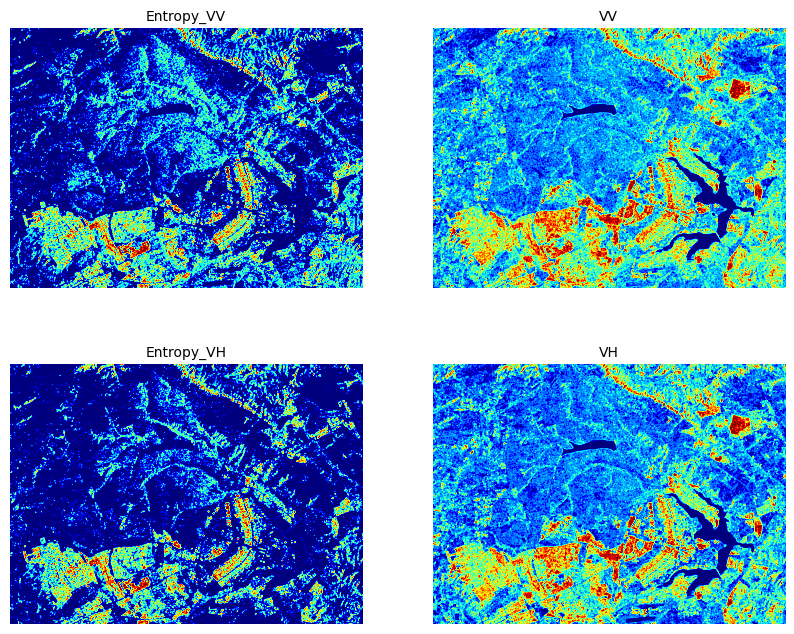

In [ ]:
# Visualização das bandas separadas
fig, axes = plt.subplots(2,2, figsize=(10,8))

axes = axes.ravel()
for i in range(gl.shape[2]):
  axes[i].imshow(stretch(gl[:,:,i]), cmap='jet')
  axes[i].set_title(nomes[i], fontsize=10)
  axes[i].axis('off')
plt.show()